# Classification trials

In [1]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [2]:
import os
from io import StringIO

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn.metrics as mr
from azure.storage.blob import BlobServiceClient
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    RepeatedKFold,
    ShuffleSplit,
    StratifiedKFold,
    train_test_split,
)
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
)

In [3]:
%aimport src.altair_helpers
from src.altair_helpers import (
    plot_altair_grid,
    alt_plot_metric_based_threshold_tuning_plots,
)

%aimport src.business_helpers
from src.business_helpers import int_income_calculator

%aimport src.custom_learning_curve_helpers
from src.custom_learning_curve_helpers import learning_curve, manual_learning_curve

%aimport src.custom_permutation_importance_helpers
from src.custom_permutation_importance_helpers import manual_plot_permutation_importance

%aimport src.custom_threshold_tuning_plotting_helpers
from src.custom_threshold_tuning_plotting_helpers import (
    plot_cost_function_based_threshold_tuning_plots,
    plot_metric_based_threshold_tuning_plots,
)

%aimport src.custom_transformers
import src.custom_transformers as ct

%aimport src.custom_returns_plotter
from src.custom_returns_plotter import plot_returns

%aimport src.ml_helpers_v2
from src.ml_helpers_v2 import get_best_pipes, gridsearch

%aimport src.ml_metrics_v2
from src.ml_metrics_v2 import (
    threshold_roc_auc_score,
    threshold_fpr_score,
    threshold_f2_score,
    threshold_recall_score,
    pr_auc_score,
    get_scores,
    get_eval_metrics,
)

%aimport src.threshold_tuning_helpers
from src.threshold_tuning_helpers import (
    get_components_of_returns,
    threshold_tuning_reshaping,
)

%aimport src.visualization_helpers
from src.visualization_helpers import (
    plot_learning_curve,
    plot_permutation_importances,
    plot_grouped_bar_chart,
    plot_grouped_histogram,
    plot_pr_roc_curves,
)

In [4]:
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_colwidth", 500)
pd.set_option("display.width", 1000)

## About

This notebook will walk through machine learning classification experiments on the raw [Lending Club loans data](https://www.lendingclub.com/auth/login?login_url=%2Fstatistics%2Fadditional-statistics%3F). A best-performing model will then be determined and assessed in the context of the business use case for this project.i.e. an conservative investor wanting to use the model developed here to predict which loan applications on the [Lending Club platform](https://www.lendingclub.com/), will not [default](https://en.wikipedia.org/wiki/Default_(finance)), and therefore should be funded by them.

## User Inputs

User inputs and helper functions, to be used later, are defined below

In [5]:
raw_data_file_path = "data/raw/lending_club_loans.csv"
cloud_storage = "no"

# From Feature Reduction
nan_threshold = 0.5
non_useful_cols = ["url", "desc"]
datetime_cols = ["issue_d", "last_pymnt_d"]
cols_one_eighteen = [
    "id",
    "member_id",
    "funded_amnt",
    "funded_amnt_inv",
    "grade",
    "sub_grade",
    "emp_title",
]
cols_eighteen_thirtysix = [
    "zip_code",
    "out_prncp",
    "out_prncp_inv",
    "total_pymnt",
    "total_pymnt_inv",
    "total_rec_prncp",
]
cols_thirtyseven_end = [
    "total_rec_int",
    "total_rec_late_fee",
    "recoveries",
    "collection_recovery_fee",
    "last_pymnt_amnt",
]
loan_status = ["Fully Paid", "Charged Off"]
mapping_dictionary_labels = {"loan_status": {"Fully Paid": 1, "Charged Off": 0}}
four_or_less_value_columns = ["pymnt_plan"]

# From Feature Processing
more_than_one_pct_missing_columns = ["pub_rec_bankruptcies"]
datetime_cols_v2 = ["last_credit_pull_d", "earliest_cr_line"]
high_cardinality_cols = ["addr_state"]
mapping_dict_emp_length = {
    "emp_length": {
        "10+ years": 10,
        "9 years": 9,
        "8 years": 8,
        "7 years": 7,
        "6 years": 6,
        "5 years": 5,
        "4 years": 4,
        "3 years": 3,
        "2 years": 2,
        "1 year": 1,
        "< 1 year": 0,
        "n/a": 0,
    }
}
nominal_columns = ["home_ownership", "verification_status", "purpose", "term"]
repeated_data_cols = ["title"]
pct_to_numeric_cols = ["int_rate", "revol_util"]

# From Exploratory Data Analysis 1/2
correlated_features = [
    # "total_acc",
    "installment",
    "fico_range_low",
    "fico_range_high",
]
look_ahead_features = ["last_fico_range_low", "last_fico_range_high"]
raw_labels = ["loan_status"]
new_labels = ["is_default"]

cols_to_show = [
    "preprocessor_type",
    "resamplers",
    "threshold",
    "params",
    "mean_test_recall_binary",
    "mean_test_fpr",
    "mean_test_auc",
    "mean_train_recall_binary",
    "mean_train_fpr",
    "mean_train_auc",
    "mean_fit_time",
    "std_train_recall_binary",
    "std_test_recall_binary",
    "std_train_fpr",
    "std_test_fpr",
    "mean_score_time",
    "clf_params",
]

thresholds_list = np.arange(0.01, 1, 0.01)

In [6]:
nan_threshold = float(nan_threshold)
for k in ["Fully Paid", "Charged Off"]:
    mapping_dictionary_labels["loan_status"][k] = int(
        mapping_dictionary_labels["loan_status"][k]
    )
for k in [
    "10+ years",
    "9 years",
    "8 years",
    "7 years",
    "6 years",
    "5 years",
    "4 years",
    "3 years",
    "2 years",
    "1 year",
    "< 1 year",
    "n/a",
]:
    mapping_dict_emp_length["emp_length"][k] = int(
        mapping_dict_emp_length["emp_length"][k]
    )

# From Exploratory Data Analysis 2/2
mapping_dict_new_labels = {"is_default": {0: 1, 1: 0}}

In [7]:
multi_scorers = {
    "recall_binary": mr.make_scorer(
        threshold_recall_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "fpr": mr.make_scorer(
        threshold_fpr_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=0.5,
    ),
    "f2": mr.make_scorer(
        threshold_f2_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "roc_auc_binary": mr.make_scorer(
        threshold_roc_auc_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=0.5,
    ),
    "pr_auc": mr.make_scorer(
        pr_auc_score,
        greater_is_better=True,
        needs_proba=True,
    ),
}
cols_to_show = [
    "mean_test_recall_binary",
    "mean_test_fpr",
    "mean_test_roc_auc_binary",
    "mean_test_pr_auc",
    "mean_train_recall_binary",
    "mean_train_fpr",
    "mean_train_roc_auc_binary",
    "mean_train_pr_auc",
    "mean_fit_time",
    "std_train_recall_binary",
    "std_test_recall_binary",
    "std_train_fpr",
    "std_test_fpr",
    "std_train_roc_auc_binary",
    "std_test_roc_auc_binary",
    "std_train_pr_auc",
    "std_test_pr_auc",
    "mean_score_time",
]

## Load data

Raw data from Lending Club is loaded into memory

In [8]:
if cloud_storage == "yes":
    az_storage_container_name = "myconedesx7"
    conn_str = (
        "DefaultEndpointsProtocol=https;"
        f"AccountName={os.getenv('AZURE_STORAGE_ACCOUNT')};"
        f"AccountKey={os.getenv('AZURE_STORAGE_KEY')};"
        f"EndpointSuffix={os.getenv('ENDPOINT_SUFFIX')}"
    )
    blob_service_client = BlobServiceClient.from_connection_string(conn_str=conn_str)

    blobstrings = {}
    for blob_name in ["blobedesz38"]:
        blob_client = blob_service_client.get_blob_client(
            container=az_storage_container_name, blob=blob_name
        )
        blobstring = blob_client.download_blob().content_as_text()
    df = pd.read_csv(StringIO(blobstring), skiprows=1, low_memory=False)
else:
    df = pd.read_csv(raw_data_file_path, skiprows=0, low_memory=False)

## Train-Test split

A hold-out set of the raw data will be set aside for model assessment

In [9]:
df_train_val, df_test = train_test_split(df, test_size=0.33, random_state=4321)
df_train, df_val = train_test_split(df_train_val, test_size=0.33, random_state=4321)

## Data processing

The raw data is cleaned, filtered and features are extracted/selected from this processed data in order to run experiments in classification

In [10]:
pipe_1_2_3 = Pipeline(
    [
        # nan_threshold=0.5, is a float in [0, 1.0] - CAN CHANGE OR KEEP UNCHANGED
        ("nanthresh", ct.DFNanThresholdColumnDropper(0.5)),
        ("nouse", ct.DFColumnDropper(non_useful_cols)),
        ("dtime", ct.DFColumnDropper(datetime_cols)),
        ("c1", ct.DFColumnDropper(cols_one_eighteen)),
        ("c2", ct.DFColumnDropper(cols_eighteen_thirtysix)),
        ("c3", ct.DFColumnDropper(cols_thirtyseven_end)),
        (
            "mapstatus",
            ct.DFColumnFilterList("loan_status", loan_status),
        ),
        ("colmap", ct.DFColumnMapper(mapping_dictionary_labels)),
        ("onevals", ct.DFNonUniqueValColDropper(num_non_unique_vals=1)),
        # four_or_less_value_columns=['pymnt_plan'] - 'pymnt_plan' is MOSTLY 'n', EXCLUDE
        ("fourvals", ct.DFColumnDropper(four_or_less_value_columns)),
        # more_than_one_pct_missing_columns = ['pub_rec_bankruptcies']
        ("morethan1pctnan", ct.DFColumnDropper(more_than_one_pct_missing_columns)),
        ("nan", ct.DFDropNaN()),
        # high_cardinality_cols=['addr_state'] - CAN INCLUDE OR EXCLUDE
        ("hcardcols", ct.DFColumnDropper(high_cardinality_cols)),
        ("dtimev2", ct.DFColumnDropper(datetime_cols_v2)),
        ("texttonum", ct.DFColumnMapper(mapping_dict_emp_length)),
        ("repeats", ct.DFColumnDropper(repeated_data_cols)),
        ("pctcols", ct.DFPctNumeric(pct_to_numeric_cols, "%")),
        (
            "singlecolmap",
            ct.DFSingleColumnMapper("loan_status", mapping_dict_new_labels),
        ),
        ("dtype", ct.DFSimpleDtypeChanger(new_labels, "int")),
        # n_std is an integer - CAN CHANGE OR KEEP UNCHANGED
        ("stdfilter", ct.DFColumnStdFilter("annual_inc", 3)),
        # correlated_features=['total_acc','installment','fico_range_low','fico_range_high'] EXCLUDE
        ("corr", ct.DFColumnDropper(correlated_features)),
        ("lookahead", ct.DFColumnDropper(look_ahead_features)),
        ("label", ct.DFColumnDropper(raw_labels)),
        # requires ("corr", ...) to be removed; threshold=1, ideally chosen from dendogram
        # ("clusterselect", ct.DFHierarchicalClusterSpearmanRank(threshold=1)),
    ]
)
df_pipe_transformed_train = pipe_1_2_3.fit_transform(df_train)
df_pipe_transformed_val = pipe_1_2_3.transform(df_val)
df_pipe_transformed_train_val = pipe_1_2_3.transform(df_train_val)
df_pipe_transformed_test = pipe_1_2_3.transform(df_test)
print(df_pipe_transformed_train.shape)
print(df_pipe_transformed_val.shape)
print(df_pipe_transformed_train_val.shape)
print(df_pipe_transformed_test.shape)
display(df_pipe_transformed_train.head(2))
display(df_pipe_transformed_val.head(2))
display(df_pipe_transformed_train_val.head(2))
display(df_pipe_transformed_test.head(2))
display(df_pipe_transformed_train["is_default"].squeeze().value_counts(dropna=False))

(16998, 17)
(8347, 17)
(25361, 17)
(12469, 17)


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,is_default
36400,4800.0,36 months,11.89,10,RENT,41300.0,Not Verified,debt_consolidation,18.65,0.0,1.0,5.0,1.0,4224.0,40.2,22.0,0
20156,12000.0,60 months,14.91,1,MORTGAGE,36000.0,Source Verified,major_purchase,13.43,0.0,3.0,8.0,1.0,5049.0,78.9,17.0,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,is_default
22692,1800.0,36 months,12.61,0,MORTGAGE,36000.0,Source Verified,other,6.30,0.0,1.0,14.0,0.0,5903.0,36.9,20.0,0
13071,6000.0,36 months,6.99,9,RENT,65000.0,Verified,debt_consolidation,28.45,0.0,0.0,7.0,0.0,13041.0,42.9,13.0,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,is_default
39296,15250.0,36 months,11.34,10,MORTGAGE,75000.0,Not Verified,debt_consolidation,15.14,0.0,0.0,11.0,0.0,39702.0,84.5,18.0,0
2652,6000.0,36 months,15.96,4,RENT,72000.0,Not Verified,credit_card,4.15,0.0,2.0,7.0,0.0,7600.0,82.6,11.0,0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,is_default
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8,30.0,1
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2,19.0,1


0    14547
1     2451
Name: is_default, dtype: int64

## Get features and class labels from processed data

The features and labels are now extracted from the processed training and testing splits

In [11]:
X_train = df_pipe_transformed_train.drop(labels=new_labels, axis=1)
y_train = df_pipe_transformed_train[new_labels].astype(int).squeeze()
X_val = df_pipe_transformed_val.drop(labels=new_labels, axis=1)
y_val = df_pipe_transformed_val[new_labels].astype(int).squeeze()
X_train_val = df_pipe_transformed_test.drop(labels=new_labels, axis=1)
y_train_val = df_pipe_transformed_test[new_labels].astype(int).squeeze()
X_test = df_pipe_transformed_test.drop(labels=new_labels, axis=1)
y_test = df_pipe_transformed_test[new_labels].astype(int).squeeze()
display(X_train.head(2))
display(X_val.head(2))
display(X_test.head(2))
display(X_train_val.head(2))
display(y_train.to_frame().head(2))
display(y_val.to_frame().head(2))
display(y_test.to_frame().head(2))
display(y_train_val.to_frame().head(2))

,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
36400,4800.0,36 months,11.89,10,RENT,41300.0,Not Verified,debt_consolidation,18.65,0.0,1.0,5.0,1.0,4224.0,40.2,22.0
20156,12000.0,60 months,14.91,1,MORTGAGE,36000.0,Source Verified,major_purchase,13.43,0.0,3.0,8.0,1.0,5049.0,78.9,17.0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
22692,1800.0,36 months,12.61,0,MORTGAGE,36000.0,Source Verified,other,6.30,0.0,1.0,14.0,0.0,5903.0,36.9,20.0
13071,6000.0,36 months,6.99,9,RENT,65000.0,Verified,debt_consolidation,28.45,0.0,0.0,7.0,0.0,13041.0,42.9,13.0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8,30.0
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2,19.0


,loan_amnt,term,int_rate,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
9990,8450.0,60 months,11.49,1,RENT,42000.0,Source Verified,debt_consolidation,24.71,0.0,0.0,12.0,0.0,8252.0,23.8,30.0
27119,13000.0,60 months,15.58,4,RENT,109896.0,Source Verified,wedding,12.28,0.0,0.0,11.0,0.0,13.0,0.2,19.0


,is_default
36400,0
20156,0


,is_default
22692,0
13071,0


,is_default
9990,1
27119,1


,is_default
9990,1
27119,1


## Assemble components for `GridSearchCV`

The pipeline inputs and other components required for hyperparameter optimization using `GridSearchCV` are extracted here

### Lists of features by type

A list of numerical and categorical features is extracted from the processed data
- numerical features are those with a datatype of `float`
- categorical features are those that do not have a datatype of `float`

In [12]:
numerical_columns = [
    c
    for c in list(X_train.select_dtypes(exclude="object"))
    if c not in new_labels + ["emp_length"]
]
nominal_columns = list(X_train.select_dtypes(include="object")) + ["emp_length"]
try:
    assert set(numerical_columns + nominal_columns) == set(list(X_train)) - set(
        new_labels
    )
    print("Columns from training data match feature lists")
except AssertionError as e:
    print("Some columns from training data are missing from feature lists")
print("Categoricals:\n-" + "\n-".join(nominal_columns))
print("Numericals:\n-" + "\n-".join(numerical_columns))

Columns from training data match feature lists
Categoricals:
-term
-home_ownership
-verification_status
-purpose
-emp_length
Numericals:
-loan_amnt
-int_rate
-annual_inc
-dti
-delinq_2yrs
-inq_last_6mths
-open_acc
-pub_rec
-revol_bal
-revol_util
-total_acc


### Feature transformations

Below, feature transformations to be applied to all numerical columns are defined. With or without transformations, all numerical features will be normalized. All categorical features will be one-hot encoded.

In [13]:
col_transformers = {
    c: Pipeline(
        steps=[
            ("trans", ct.DFPowerTransformer("yeo-johnson")),
            ("ss", ct.DFStandardScaler()),
        ]
    )
    for c in numerical_columns
}
preprocessors = {
    "no_trans": ColumnTransformer(
        transformers=[
            (
                "nums",
                Pipeline(steps=[("trans", StandardScaler())]),
                numerical_columns,
            )
        ]
        + [("onehot", OneHotEncoder(handle_unknown="ignore"), nominal_columns)],
        remainder="passthrough",
    ),
    "trans": ColumnTransformer(
        transformers=[(k, v, [k]) for k, v in col_transformers.items()]
        + [("onehot", OneHotEncoder(handle_unknown="ignore"), nominal_columns)],
        remainder="passthrough",
    ),
}

### Classifiers and hyper-parameters for optimization

The models to be compared, discrimination threshold(s) (to be applied to all listed models), and dictionaries of model hyper-parameters for tuning, are defined below
- for hyper-parameter dictionaries containing cost-function weights, for manual specification of the penalties used in the algorithm's cost function, the larger penalty should be assigned to the minority class (see [**Lesson 07. Cost-Sensitive Algorithms**](https://machinelearningmastery.com/imbalanced-classification-with-python-7-day-mini-course/))
  - here, this is for the positive class where `is_default`==1, and is explicitly shown below through the class-balance of the labels from the training data

In [14]:
y_train.value_counts().to_frame()

,is_default
0,14547
1,2451


In [15]:
vc = np.unique(y_train, return_counts=True)[1]
minority_weight = vc[0] / vc[1]
parameters = {
    "LogisticRegression": {
        "C": [1.0],
        "class_weight": [
            "balanced",
            None,
            {0: 1, 1: 1},
            {0: 1, 1: minority_weight},
            {0: 1, 1: 8},
        ],
    },
    "DummyClassifier": {"strategy": ["stratified"]},
}

In [16]:
%%time
cv = StratifiedKFold(n_splits=5, shuffle=False)
df_gs = gridsearch(
    X_train,
    y_train,
    parameters,
    preprocessors["no_trans"],
    cv,
    multi_scorers,
    threshold=0.5,
)
param_cols = df_gs.columns[
    df_gs.columns.to_series().str.contains("param_")
].tolist()
display(df_gs[["clf"]+param_cols+cols_to_show])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  25 | elapsed:    2.5s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    2.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   5 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


,clf,param_clf__C,param_clf__class_weight,param_clf__strategy,mean_test_recall_binary,mean_test_fpr,mean_test_roc_auc_binary,mean_test_pr_auc,mean_train_recall_binary,mean_train_fpr,mean_train_roc_auc_binary,mean_train_pr_auc,mean_fit_time,std_train_recall_binary,std_test_recall_binary,std_train_fpr,std_test_fpr,std_train_roc_auc_binary,std_test_roc_auc_binary,std_train_pr_auc,std_test_pr_auc,mean_score_time
0,LogisticRegression,1,balanced,NaN,0.629537,0.343577,0.642980,0.286464,0.643717,0.340465,0.651626,0.293861,0.507399,0.005650,0.017472,0.002314,0.010124,0.003529,0.008925,0.002647,0.010325,0.128292
1,LogisticRegression,1,None,NaN,0.022851,0.003849,0.509501,0.286977,0.024072,0.003523,0.510274,0.295986,0.926422,0.001268,0.005075,0.000435,0.001218,0.000695,0.002055,0.002718,0.009664,0.104031
2,LogisticRegression,1,"{0: 1, 1: 1}",NaN,0.022851,0.003849,0.509501,0.286977,0.024072,0.003523,0.510274,0.295986,0.859442,0.001268,0.005075,0.000435,0.001218,0.000695,0.002055,0.002718,0.009664,0.055639
3,LogisticRegression,1,"{0: 1, 1: 5.935128518971848}",NaN,0.630354,0.343439,0.643457,0.286418,0.643615,0.340414,0.651600,0.293860,0.507477,0.005460,0.017833,0.002275,0.010071,0.003478,0.009218,0.002648,0.010275,0.025011
4,LogisticRegression,1,"{0: 1, 1: 8}",NaN,0.767438,0.485462,0.640988,0.286240,0.776928,0.483794,0.646567,0.293485,0.398022,0.002226,0.022427,0.005247,0.005766,0.003128,0.011478,0.002673,0.010304,0.018033
5,DummyClassifier,NaN,NaN,stratified,0.152179,0.142435,0.504872,0.213493,0.154019,0.141180,0.506419,0.215637,0.054491,0.003669,0.011319,0.000614,0.001917,0.002142,0.006618,0.003403,0.010556,0.020418


CPU times: user 1.4 s, sys: 2.23 s, total: 3.63 s
Wall time: 3.51 s


In [17]:
best_cfg_idx = 0
best_dummy_cfg_idx = 5
best_pipe, best_dummy_pipe = get_best_pipes(
    best_cfg_idx, best_dummy_cfg_idx, df_gs, preprocessors["no_trans"], param_cols
)

In [18]:
_, confs = get_components_of_returns(X_val)
confs

[{'r': 10.71, 'n': ' 36 months', 'p': 500.0, 'ret': 86.82798290297922},
 {'r': 7.9, 'n': ' 36 months', 'p': 35000.0, 'ret': 4425.720020766101},
 {'r': 23.59, 'n': ' 60 months', 'p': 35000.0, 'ret': 24914.007363151228},
 {'r': 14.91, 'n': ' 60 months', 'p': 9900.0, 'ret': 4203.172176331318}]

In [19]:
%%time
best_pipe.fit(X_train, y_train)
best_dummy_pipe.fit(X_train, y_train)
y_probs_val = best_pipe.predict_proba(X_val)[:, 1]

CPU times: user 726 ms, sys: 1.38 s, total: 2.1 s
Wall time: 206 ms


In [20]:
%%time
(
    df_threshold_tuning_scores,
    df_all_threshold_tuning_scores
) = plot_metric_based_threshold_tuning_plots(
    y_val,
    y_probs_val,
    thresholds_list,
    f2_beta=2,
    legend_position=(1.01, 1),
    show_best_t_by_f1=False,
    show_plot=False,
    fig_size=(8, 4),
)
display(df_threshold_tuning_scores)

,best_threshold,score
ROC-AUC,0.49,0.639368
Precision,0.90,0.949285
Recall,0.01,1.000000
F1,0.32,0.693046
FPR,0.01,1.000000
F2,0.19,0.837268


CPU times: user 136 ms, sys: 89 ms, total: 225 ms
Wall time: 483 ms


1. this is the sum of `n` [monthly returns](https://www.vertex42.com/ExcelArticles/amortization-calculation.html) that a prospective funder of the loan would expect to receive if the loan is paid off on time
2. Why divide by `len(y_test)`?
   - If every loan had these r,n,p, anbd other factos were consisnt, and taking the model's predictive power into account, then the average return would be given by `ds /= len(y_test)`

#### Methodology for tuning threshold

An alternative approach to tune the discrimination threshold involves optimizing the total return earned (or lost) by an investor that only follows the predictions of the ML model when deciding whether a loan will result in a default (investor does not fund) or will be paid off on time (investor provides funding).

The total return earned on a loan is the sum of monthly payments made by the borrower. A monthly payment for a loan can be calculated using the formula ([1](https://www.kasasa.com/blog/how-to-calculate-loan-payments-in-3-easy-steps), [2](https://www.vertex42.com/ExcelArticles/amortization-calculation.html), [3](https://www.calculator.net/payment-calculator.html), [4](https://www.thebalance.com/loan-payment-calculations-315564)) below

![\Large A=P\frac{r{(1+r)^n}}{(1+r)^n-1}](https://latex.codecogs.com/svg.latex?\Large&space;A=P\frac{r(1+r)^n}{(1+r)^n-1})

The three terms in this formula for monthly interest payment (`A`) are in the Lending Club dataset
- `int_rate` is the interest rate per year (`r`), expressed as a percentage
  - this will have to be divided by 12 to get the monthly interest rate due on the loan
- `loan_amnt` is the principal (`P`), or value of the loan in dollars (USD)
- `term` is the length of time that a borrower has to repay the loan (`n`), in months and so the number of periodic (monthly) payments that are to be made on the loan
  - for the dataset here, this is 36 or 60 months

Using this formula, the monthly payment amount (`A`) can be calculated in dollars and it matches the value found in the `installment` column of the data, though that column is not used as an ML feature here. The sum of all the monthly payments (36 or 60) is the total interest payment on the loan (A<sub>t</sub>). Note that `A` is the total monthly payment including interest. The interest component of the first monthly payment (`A`) is `r` X `P` and the new principal after the first payment is made would be `P` - `A`. The interest component of the second monthly payment is `r` X (`P` - `A`) and so on.

Here, the total of all the monthly payments on a loan (A<sub>t</sub>) is calculated in Python for all loans in the validation split of the data using a helper function `int_income_calculator()` found in `src/business_helpers.py`.

This total income earned by an investor is used in determining the prospective return that can be earned per loan by relying on the predictions made by the ML model being developed here. A positive return indicates the investor could receive funds by relying on the ML model, while a negative return indicates that the investor would actually lose money if they relied on the ML model when deciding whether to fund the loan or not.

Recalling that the positive class here is that a borrower will default and the negative class is that the loan will be paid off on time, the four types of outcomes that need to be considered when estimating the returns earned by relying on the ML model's predictions and are discussed below
1. If an ML model predicts a loan will be paid on time and it actually is, then this is the overall return that an investor will theoretically earn by funding the loan. This is the cost of a True Negative.
2. If the ML model predicts the loan will result in a default and the loan is actually paid off on time, then this is the prospective loss incurred by the investor by not funding the loan. Since the investor follows the model's recommendation, and does not provide funding, principal is not lost. However, return was there to be earned - and it wasn't! So, the return is lost. This is the cost of a False Positive.
3. If the ML model predicts that the loan will be paid off on time and it actually defaults, then the principal is lost. Return was never there to be earned since the loan would have defaulted - it was going to be lost, but the model predicted the opposite. So, the return wasn't lost, but the princpal is. A simplifying assumption is made here: the borrower never made any monthly payments. This is a conservative estimate in the sense that the borrower may make a few of the required monthly payments before defaulting on the loan (when a loan payment is 121 days past due). So, the full principal may not be lost in this case. By assuming the worst case scenario (no payments made), this provides an upper bound on the funds that could be lost by a prospective investor. This is an important factor for a conservative investor - the intentend end user of the ML model being developed here. This is the cost of a False Negative.
4. If the ML model predicts that the loan will result in a default and this does happen, then neither principal nor return are lost. There was no return to be made so return was not lost. Since the investor followed the recommendations of the ML model and did not provide funding, no principal was lost either. This is the cost (or lack thereof) of a True Positive.

Using these four outcomes, the ML model's predicted return on a loan can be estimated using the formula below

![\Large R(t)=-(P)XFN(t)+(0)TP(t)+(-A_t)FP(t)+(A_t)TN(t)](https://latex.codecogs.com/svg.latex?\Large&space;R(t)=-(P)FN(t)+(0)TP(t)+(-A_t)FP(t)+(A_t)TN(t))

where `FN(t)`, `FP(t)`, `TN(t)` and `TP(t)` are the number of false negatives, false positives, true negatives and true positives respectively and can be extracted from a [confusion matrix](https://classeval.wordpress.com/introduction/basic-evaluation-measures/). Each of these is a function of the discrimination threshold - this means the choice of threshold determines the number of false negatives, true positives, etc. predicted by the model. `R(t)` also depends on the threshold. When applied to the ML model's prediction of a outcome of a single loan, three of `FN`, `FP`, `TN` and `TP` are 0 and the fourth value is 1. `P` is the principal for the loan in question and A<sub>t</sub> is the theoretical return (total of all the monthly payments) that could be earned or lost and was calculated above. Each of `FN`, `FP`, `TN` and `TP` is a function of the discrimination threshold, `t`.

`R(t)` above can be computed for the ML model's predictions of the class labels (R<sub>pred</sub>(t)) and for the true labels (R<sub>true</sub>(t)). The optimal value of `t` is one that minimizes the mean absolute difference between predicted (R<sub>pred</sub>(t)) and true (R<sub>true</sub>(t)) returns across all loans being considered in the data

![\Large AE(t)=|R_{pred}(t)-R_{true}(t)|](https://latex.codecogs.com/svg.latex?\Large&space;AE(t)=|R_{pred}(t)-R_{true}(t)|)

![\Large MAE(t)=\overline{AE(t)}=\frac{AE(t)}{len(R_{pred})}](https://latex.codecogs.com/svg.latex?\Large&space;MAE(t)=\overline{AE(t)}=\frac{AE(t)}{len(R_{pred})})

This optimized discrimination threshold is taken as the best value for the business use case being analyzed here. This optimal `t` will **not** necessarily agree with the choice of `t` that optimizes the ML scoring metrics as shown in the table above (see the `best_threshold` column) - instead, it is an alternative to the one that is designed to optimize ML scoring metrics.

#### Technical details of threshold tuning

1. Starting with the best model found from hyper-parameter optimization, extract the columns required to calculate the total of all monthly payments on the loans in the data - these are `int_rate`, `loan_amnt` and `term`. The helper function `int_rate_calculator()` computes the total return on a single loan and it will be vectorized to perform this computation on all the loans in the validation split. This gives a single column of the total return for each loan.
2. Why the validation split? Since the best model was already determined during hyper-parameter tuning, it will be re-used. As hyper-parameters were tuned on the training split, the trained (best) model will not be re-trained during threshold tuning. Instead, it will be used to generate the class prediction probabilities for all observations in the validation split.
3. A helper function `rowwise_calculate_avg_return_vs_theoretical()` is used to calculate the difference between the ML model's predicted return on a single loan using the formula for `Returns(t)` defined earlier. This functin will use
- predicted probability (converted to a hard label - 0 or 1) and corresponding true value from the validation split
- principal, since this is the penalty for a false negative
- total loan income
  - this is the output of vectorizing the `int_rate_calculator()` helper function

to calculate the predicted return for each loan and true return for each loan. Using the predicted (hard) class label and the true label (`confusion_matrix(y_pred, y_true)`), a single-entry confusion matrix similar to
```
0 0
1 0
```
is used to extract `FN`, `FP`, `TN` and `TP` and then calculate the predicted return. For the true return, the predicted class label is repeated by the true label (`confusion_matrix(y_true, y_true)`) and the confusion matrix is similarly used to calculated the true return. The difference between the predicted and true return is then computed and the average differrence across all loans will be used as the `MAE` scoring metric for optimizing the threshold.

In [178]:
from multiprocessing import cpu_count

from joblib import Parallel, delayed
import matplotlib.ticker as mtick
import scipy.stats as st

%aimport src.business_helpers
from src.business_helpers import calculate_avg_return_vs_theoretical_v2

%aimport src.visualization_helpers
from src.visualization_helpers import add_gridlines, customize_splines

In [205]:
def score_single_threshold(X, y, pipe, t):
    score = calculate_avg_return_vs_theoretical_v2(X, y, pipe, t)
    five_percentile, ninetyfive_percentile = st.t.interval(
        0.95, len(score) - 1, loc=np.mean(score), scale=st.sem(score)
    )
    twentyfive_percentile, seventyfive_percentile = st.t.interval(
        0.75, len(score) - 1, loc=np.mean(score), scale=st.sem(score)
    )
    fifty_percentile, _ = st.t.interval(
        0.50, len(score) - 1, loc=np.mean(score), scale=st.sem(score)
    )
    r = {
        "label": type(pipe.named_steps["clf"]).__name__,
        "threshold": t,
        "mdae": score.median(),
        "stdae": score.std(),
        "count": score.count(),
        "whislo": five_percentile,
        "whishi": ninetyfive_percentile,
        "q1": twentyfive_percentile,
        "med": fifty_percentile,
        "q3": seventyfive_percentile,
        "fliers": [],
    }
    return r

In [169]:
def threshold_tuning_reshaping(df_t_tuned, get_relative_score=False):
    if get_relative_score:
        df_t_tuned = df_t_tuned.assign(
            relative_mae=(df_t_tuned["mae"] / df_t_tuned["mae"].max())
        ).drop(["mae", "stdae", "count"], axis=1)
    df_t_tuned = (
        df_t_tuned.set_index("threshold")
        .unstack()
        .reset_index()
        .rename(columns={"level_0": "metric", 0: "value"})
    )
    return df_t_tuned

In [170]:
def compute_cost_for_thresholds(
    thresholds, X_test, y_test, pipe, get_relative_score=False
):
    executor = Parallel(n_jobs=cpu_count(), backend="multiprocessing")
    tasks = (
        delayed(score_single_threshold)(
            X_test,
            y_test,
            pipe,
            t,
        )
        for t in thresholds
    )
    d = executor(tasks)
    df_cost_func = pd.DataFrame.from_records(d)
    df_cost_func = threshold_tuning_reshaping(df_cost_func, get_relative_score)
    return df_cost_func

In [108]:
%%time
df_cost_func_tuning = compute_cost_for_thresholds(thresholds_list, X_val, y_val, best_pipe, True)
display(df_cost_func_tuning)

,metric,threshold,value
0,relative_mae,0.01,1.000000
1,relative_mae,0.02,1.000000
2,relative_mae,0.03,1.000000
3,relative_mae,0.04,1.000000
4,relative_mae,0.05,0.999969
5,relative_mae,0.06,0.999876
6,relative_mae,0.07,0.999768
7,relative_mae,0.08,0.999488
8,relative_mae,0.09,0.998889
9,relative_mae,0.10,0.997961


CPU times: user 1.01 s, sys: 132 ms, total: 1.14 s
Wall time: 1min 58s


In [109]:
alt_plot_metric_based_threshold_tuning_plots(
    pd.concat([df_all_threshold_tuning_scores, df_cost_func_tuning]),
    ptitle_offset=-5,
    legend_offset=5,
    figsize=(450, 300),
)

alt.LayerChart(...)

In [206]:
%%time
dfcts = []
for pipe in [best_dummy_pipe, best_pipe]:
    df_cost_func = compute_cost_for_thresholds([best_t], X_val, y_val, pipe, False).assign(clf=type(pipe.named_steps['clf']).__name__)
    dfcts.append(df_cost_func)
df_cost_funcs = pd.concat(dfcts, ignore_index=True)
df_cost_funcs = df_cost_funcs.pivot(index="metric", columns="clf", values="value")
display(df_cost_funcs)

clf,DummyClassifier,LogisticRegression
metric,,
count,8347,8347
fliers,[],[]
label,DummyClassifier,LogisticRegression
mdae,0,0
med,2056.98,1885.85
q1,2028.94,1856.14
q3,2164.52,1999.79
stdae,5383.78,5704.04
whishi,2212.24,2050.35


CPU times: user 164 ms, sys: 139 ms, total: 303 ms
Wall time: 13 s


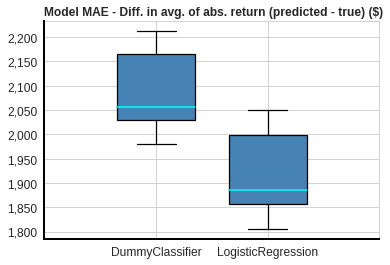

In [282]:
bxp_cols = ["label", "whislo", "q1", "med", "q3", "whishi", "fliers"]
boxes = [
    df_cost_funcs.loc[
        bxp_cols, type(best_dummy_pipe.named_steps["clf"]).__name__
    ].to_dict(),
    df_cost_funcs.loc[bxp_cols, type(best_pipe.named_steps["clf"]).__name__].to_dict(),
]
axis_tick_label_fontsize = 12
fig, ax = plt.subplots(figsize=(6, 4))
bxp1 = ax.bxp(
    boxes,
    positions=[1, 1.5],
    widths=0.35,
    showfliers=False,
    patch_artist=True,
    whiskerprops=dict(linewidth=1.25, color="black"),
    capprops=dict(linewidth=1.25, color="black"),
    boxprops=dict(linewidth=1.25),
    medianprops=dict(linewidth=1.5, color="cyan"),
)
for patch in bxp1["boxes"]:
    patch.set(facecolor="steelblue")
ax.xaxis.set_tick_params(labelsize=axis_tick_label_fontsize)
ax.yaxis.set_tick_params(labelsize=axis_tick_label_fontsize)
ax.grid(which="both", axis="both", color="lightgrey", zorder=0)
_ = customize_splines(ax)
_ = add_gridlines(ax)
ax.set_xlabel(None)
ax.set_title(
    "Model MAE - Diff. in avg. of abs. return (predicted - true) ($)",
    loc="left",
    fontweight="bold",
)
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter("{x:,.0f}"))

,r,n,p,config,best_t,return_at_best_t,theoretical,clf
0,10.71,36,500.0,0,0.01,-6.374047,86.827983,DummyClassifier
1,7.90,36,35000.0,1,0.01,-1463.615562,4425.720021,DummyClassifier
2,23.59,60,35000.0,2,0.01,11152.869036,24914.007363,DummyClassifier
3,14.91,60,9900.0,3,0.01,1403.403017,4203.172176,DummyClassifier
4,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
5,7.90,36,35000.0,1,0.61,-371.397904,4425.720021,LogisticRegression
6,23.59,60,35000.0,2,0.90,16657.707551,24914.007363,LogisticRegression
7,14.91,60,9900.0,3,0.83,2265.027300,4203.172176,LogisticRegression


config,threshold,0,1,2,3,r,n,p,config,best_t,return_at_best_t,theoretical,clf
0,0.01,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
1,0.02,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
2,0.03,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
3,0.04,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression
4,0.05,-74.834133,-3814.379996,-21472.549296,-3622.573456,10.71,36,500.0,0,0.75,10.626142,86.827983,LogisticRegression


CPU times: user 829 ms, sys: 1.56 s, total: 2.39 s
Wall time: 1.09 s


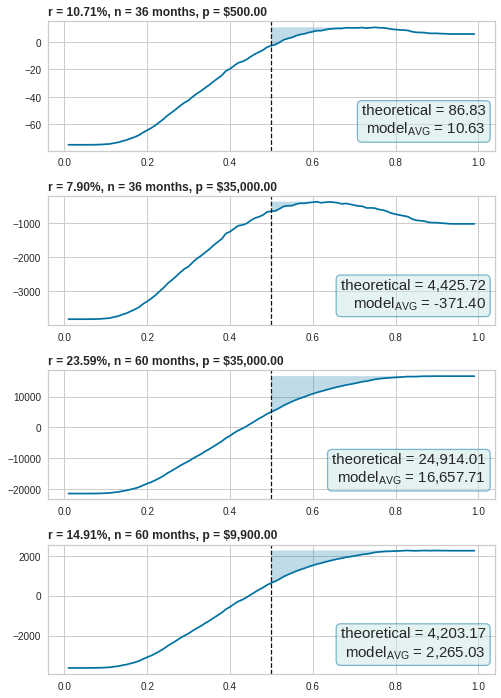

In [22]:
%%time
df_returns_t_tuned, df_returns_t_tuning_full = plot_cost_function_based_threshold_tuning_plots(best_pipe, best_dummy_pipe, X_val, y_val, confs, thresholds_list)
display(df_returns_t_tuned)
display(df_returns_t_tuning_full.head())

In [23]:
%%time
best_t = 0.75
df_returns_best_t, _ = plot_cost_function_based_threshold_tuning_plots(best_pipe, best_dummy_pipe, X_val, y_val, confs, [best_t])
df_returns_best_t = threshold_tuning_reshaping(df_returns_best_t)
display(df_returns_best_t)

,cfg,clf,return
0,"(10.71%, 36 mo., $500)",DummyClassifier,-6.374047
1,"(7.90%, 36 mo., $35,000)",DummyClassifier,-1463.615562
2,"(23.59%, 60 mo., $35,000)",DummyClassifier,11152.869036
3,"(14.91%, 60 mo., $9,900)",DummyClassifier,1403.403017
4,"(10.71%, 36 mo., $500)",LogisticRegression,10.626142
5,"(7.90%, 36 mo., $35,000)",LogisticRegression,-560.621189
6,"(23.59%, 60 mo., $35,000)",LogisticRegression,15614.988442
7,"(14.91%, 60 mo., $9,900)",LogisticRegression,2171.511279
8,"(10.71%, 36 mo., $500)",Theoretical,86.827983
9,"(7.90%, 36 mo., $35,000)",Theoretical,4425.720021


CPU times: user 345 ms, sys: 629 ms, total: 974 ms
Wall time: 400 ms


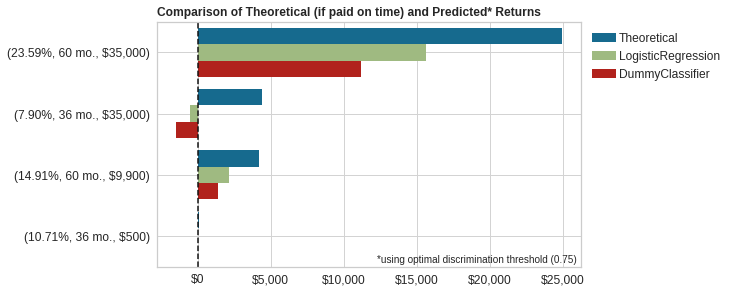

In [24]:
plot_returns(
    df_returns_best_t.sort_values(by=["clf", "return"], ascending=[False, False]),
    ptitle="Comparison of Theoretical (if paid on time) and Predicted* Returns",
    annotation_text=f"*using optimal discrimination threshold ({best_t})",
    axis_tick_fontsize=12,
    annotation_text_fontsize=10,
    annotation_loc=(0.99, 0.01),
    fig_size=(8, 4),
)

1. It is average becuase the model will not alwyas predict that you should fund such a loan. There are times when it incorrectly predicts that the loan should not be funded - in such a scenario, prospective return is lost. If you used an independent methd of predicting loans to fund, and the loan was paid off on time, then the return you earn would be the theoretical return from the above graph/table.

In [25]:
%%time
best_pipe.fit(X_train_val, y_train_val)
best_dummy_pipe.fit(X_train_val, y_train_val)
y_probs_test = best_pipe.predict_proba(X_test)[:, 1]

CPU times: user 824 ms, sys: 1.39 s, total: 2.22 s
Wall time: 209 ms


In [26]:
_, confs_test = get_components_of_returns(X_train_val)
confs_test

[{'r': 8.07, 'n': ' 36 months', 'p': 500.0, 'ret': 64.63602189022333},
 {'r': 10.46, 'n': ' 36 months', 'p': 500.0, 'ret': 84.70453976034196},
 {'r': 7.49, 'n': ' 36 months', 'p': 35000.0, 'ret': 4188.048351118239},
 {'r': 23.52, 'n': ' 60 months', 'p': 35000.0, 'ret': 24829.067510758083},
 {'r': 17.27, 'n': ' 36 months', 'p': 10000.0, 'ret': 2883.408919678688}]

In [27]:
%%time
df_returns_best_t_test, _ = plot_cost_function_based_threshold_tuning_plots(best_pipe, best_dummy_pipe, X_test, y_test, confs_test, [best_t])
df_returns_best_t_test = threshold_tuning_reshaping(df_returns_best_t_test)
display(df_returns_best_t_test)

,cfg,clf,return
0,"(8.07%, 36 mo., $500)",DummyClassifier,-20.988655
1,"(10.46%, 36 mo., $500)",DummyClassifier,-8.618246
2,"(7.49%, 36 mo., $35,000)",DummyClassifier,-1676.610825
3,"(23.52%, 60 mo., $35,000)",DummyClassifier,11046.692829
4,"(17.27%, 36 mo., $10,000)",DummyClassifier,560.741114
5,"(8.07%, 36 mo., $500)",LogisticRegression,-9.458296
6,"(10.46%, 36 mo., $500)",LogisticRegression,6.131059
7,"(7.49%, 36 mo., $35,000)",LogisticRegression,-923.455263
8,"(23.52%, 60 mo., $35,000)",LogisticRegression,15110.622176
9,"(17.27%, 36 mo., $10,000)",LogisticRegression,1046.491202


CPU times: user 356 ms, sys: 550 ms, total: 905 ms
Wall time: 346 ms


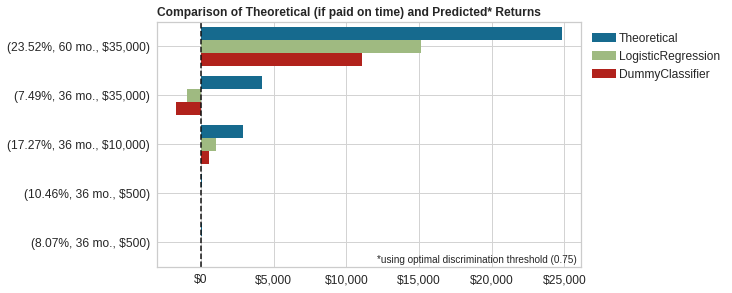

In [28]:
plot_returns(
    df_returns_best_t_test.sort_values(by=["clf", "return"], ascending=[False, False]),
    ptitle="Comparison of Theoretical (if paid on time) and Predicted* Returns",
    annotation_text=f"*using optimal discrimination threshold ({best_t})",
    axis_tick_fontsize=12,
    annotation_text_fontsize=10,
    annotation_loc=(0.99, 0.01),
    fig_size=(8, 4),
)

## Model Evaluation

### ML Diagnostic metrics and plots

In [29]:
df_scores, y_pred_test_selected_threshold = get_eval_metrics(
    y_test.to_numpy(), y_probs_test, split="test", threshold=best_t, beta=2
)
display(df_scores.T)

,0
test_recall_binary,0.159797
test_fpr,0.047299
test_f2,0.189913
test_pr_auc,0.276734
test_roc_auc,0.556249


In [30]:
df_cm = (
    pd.DataFrame(
        mr.confusion_matrix(
            y_test,
            y_pred_test_selected_threshold,
            labels=np.sort(np.unique(y_train_val)),
        ),
        index=np.sort(np.unique(y_train_val)),
        columns=np.sort(np.unique(y_train_val)),
    )
    .rename_axis("actual", axis="columns")
    .rename_axis("predicted", axis="rows")
)
df_cr = pd.DataFrame(
    mr.classification_report(
        y_test,
        y_pred_test_selected_threshold,
        target_names=np.sort(np.unique(y_train_val)),
        output_dict=True,
    )
).T
plot_altair_grid(
    df_cm,
    df_cr,
    ptitle_offset=-5,
    cpe_figsize=(150, 300),
    cm_figsize=(150, 300),
    cr_figsize=[(250, 300), (100, 300)],
)

alt.HConcatChart(...)

**Observations**
1. The poor performance is not surprising since the threshold was optimized on the cost function of predicted loan return. Each of these metrics had an optimal threshold region that was different from the threshold that maximized the difference in the prediction error expressed as a cost function - the average error in the model's predicted returns.
2. By definition, `TPR` and `F2` are close to eachother since they minimize `FN`. This was also seen earlier in the metric-based threshold tuning plots and is again observed here.

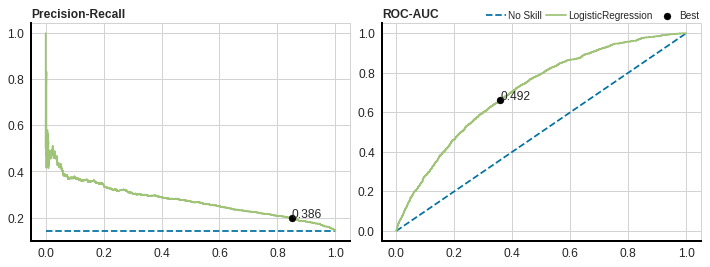

In [31]:
plot_pr_roc_curves(
    y_test,
    y_probs_test,
    type(best_pipe.named_steps["clf"]).__name__,
    axis_tick_label_fontsize=12,
    wspace=0.1,
    legend_position=(0.3, 1.1),
    f2_beta=2,
    fig_size=(12, 4),
)

**Observations**
1. Interpreting the ROC-AUC curve
   - On average, a model with skill gives a higher probability to a randomly chosen real positive outcome than a negative one.
   - A model with perfect skill is depicted as a point at `(0, 1)` (top left of the plot)
     - A model with skill produces a ROC-AUC curve that expands from the 45-degree line up to the top left of the plot.
2. Interpreting the Precision-Recall curve
   - A model with skill can discriminate between classes and does not predict a random class or a constant class in all cases.
   - The no-skill line is a horizontal line with the value of the ratio of positive cases in the dataset. Its value depends on the relative balance between positive to negative classes. For a prefectly balanced dataset, this ratio is 0.5, which is clearly not the case here.
     - for the test set here, `y_test.value_counts().to_dict()` gives `{0: 10698, 1: 1771}` and so the no-skill line is drawn at `1771/10698 = 0.1655`
   - A model with perfect skill is depicted as a point at `(1, 1)` (top right of the plot)
   - A model with skill produces a Precision-Recall curve that expands from the horizontal line, at the bottom, to the top right of the plot and is well above the horizontal line of no skill.
3. Given the imbalance in the classes here, more importance should be given to the Precision-Recall curve than to the ROC-AUC curve.
4. While both plots are clearly sub-optimal, it is reassuring that the best model found here is better than one that has no skill.
5. The optimal threshold is marked as a circle with an annotation on the
   - ROC-AUC curve
     - This is the threshold with the optimal balance between false positive and true positive rates as determined by optimizing the Geometric Mean
   - Precision-Recall curve
     - This is the threshold with the the best balance of precision and recall as determined by as optimizing the [F2 score](https://clusteval.sdu.dk/1/clustering_quality_measures/14)

### Model-Neutral Permutation Importance

In permutation importance ([1](https://academic.oup.com/bioinformatics/article/26/10/1340/193348), [2](https://docs.cloud.oracle.com/en-us/iaas/tools/ads-sdk/latest/user_guide/mlx/permutation_importance.html#description)), each column is iteratively randomized and used as an input for modeling. The difference in scoring metric with and without this randomization is taken as the importance of the column being randomized to the model. This process is repeated for each column individually. It provides a model agnostic indication of the importance of each feature, independent of how the algorithm's coefficients/importances are computed. The method requires the absence of multi-collinearity between ML features and that is the case here since correlated features were manually removed during exploratory data analysis.

**Methodology Used**
1. For a given (`r`, `n`, `P`), calculate
   - predicted return per loan ( `A` )
     - calculate predicted return from confusion matrix, using formula for `ds`
       - this takes ML model's predictive power into account
   - true return per loan (`B`)
2. Calculate difference (`D`) between predicted and theoretical returns
   - `D` = `A` - `B`
3. Calculate mean of all differences in the testing data
   - this gives the average difference between the return predicted by the model and the return earned (depending on whether the loan was paid off on time or not), per loan ( $\overline{D}$ )
4. Shuffle single ML feature and re-calculate mean of differences ( $\overline{D}$ ) from step 2.
4. Calculate difference (`D1`) bewteen mean values found in steps 2. (without shuffling) and 3. (with shuffling)
5. Repeat steps 2. to 4. `n_repeats` times
   - in other words, shuffle the same column `n_repeats` times and calculate the differences (`D2`, ..., `D10`) between the predicted and true returns
6. Plot all the differences `D1`, ..., `D10`
7. The higher the difference the more impactful the ML feature is to the predictive model developed here

Below is a boxplot highlighting the impact on model performance, separately using the TPR (minimizes `FN`), FPR and F2 score (the prefered metric for imbalanced data where `FN` is more important than `FP`) as the scoring metric, of randomizing columns from the testing data individually (i.e. as determined using the permutation importance)

CPU times: user 392 ms, sys: 824 ms, total: 1.22 s
Wall time: 1.1 s


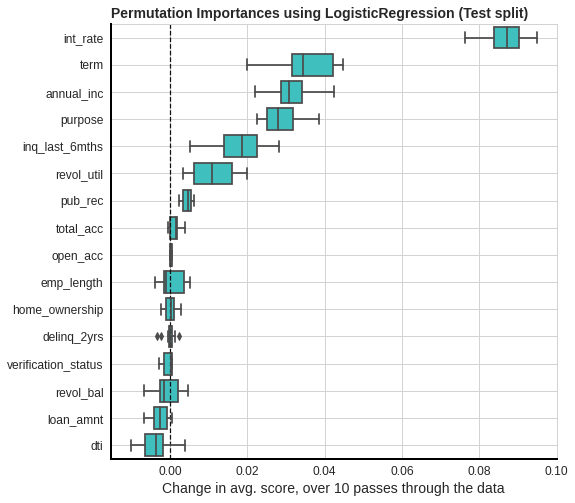

In [35]:
%%time
plot_permutation_importances(
    best_pipe,
    X_test,
    y_test,
    scorer=multi_scorers["recall_binary"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(8, 8),
)

CPU times: user 405 ms, sys: 783 ms, total: 1.19 s
Wall time: 947 ms


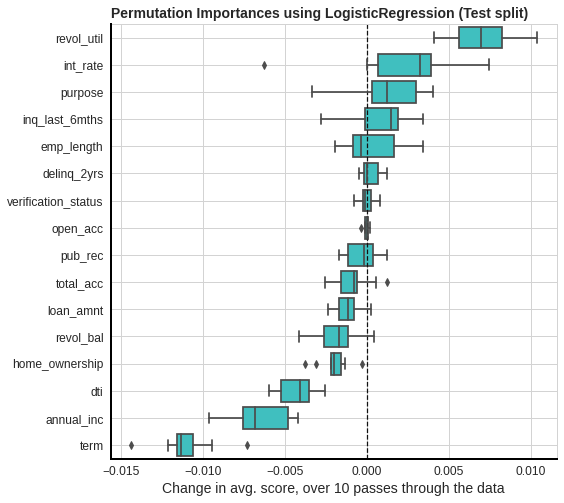

In [36]:
%%time
plot_permutation_importances(
    best_pipe,
    X_test,
    y_test,
    scorer=multi_scorers["fpr"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(8, 8),
)

CPU times: user 391 ms, sys: 860 ms, total: 1.25 s
Wall time: 1.1 s


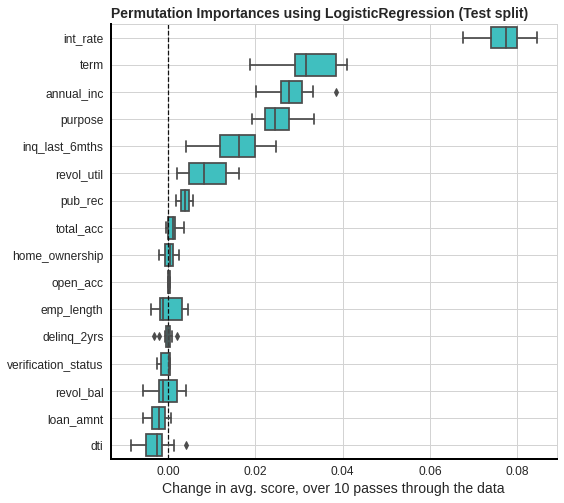

In [37]:
%%time
plot_permutation_importances(
    best_pipe,
    X_test,
    y_test,
    scorer=multi_scorers["f2"],
    n_repeats=10,
    fig_title_fontsize=14,
    fig_title_vertical_pos=0.97,
    axis_tick_label_fontsize=12,
    axis_label_fontsize=14,
    box_color="cyan",
    fig_size=(8, 8),
)

The process is repeated using the difference between the average difference of the model's predicted, and true return, per loan in the testing split as the scoring metric instead of the the TPR and FPR separately

CPU times: user 10.3 s, sys: 1.02 s, total: 11.3 s
Wall time: 2min 48s


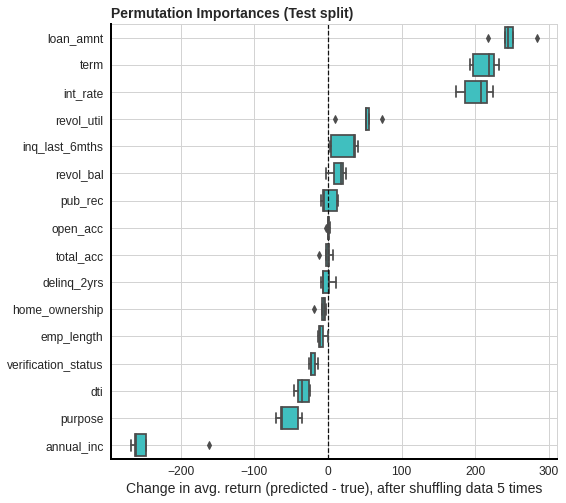

In [38]:
%%time
manual_plot_permutation_importance(
    X_test,
    y_test,
    best_pipe,
    best_t,
    5,
    "test",
    "Permutation Importances",
    14,
    12,
    14,
    "cyan",
    (8,8),
)

**Observations**
1. The `int_rate` (loan's interest rate), `term` (duration of loan) and `loan_amnt` (principal) are required to calculate the interrest income which is used in converting the model's predictions to the per-loan return. By definition, shuffling each of these columns individually will affect this conversion. So, it is not surprising that these three are the most important factors as determined by permutation importance.
2. Not surprisingly, annual income followed by purpose were the two most influential value-add variables in the data. The annual income is more important than the length of employment - a higher earner is more impactful on the ability to pay off a loan than an applicant who has been working longer (but not earning a high salary).
3. Since this is the **average** difference in dollars (horizontal axis) per loan, the marginal value increases in the per-loan return between pairs of features (eg. `annual_inc` vs `purpose`) should also be interpreted as an average rather than a discrete value that can be expected for every single loan.

In [ ]:
multi_scorers = {
    "recall_binary": mr.make_scorer(
        threshold_recall_score,
        greater_is_better=True,
        needs_proba=True,
        threshold=best_t,
    ),
    "f2": mr.make_scorer(
        threshold_fpr_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=best_t,
    ),
    "fpr": mr.make_scorer(
        threshold_f2_score,
        greater_is_better=False,
        needs_proba=True,
        threshold=best_t,
    ),
}

### Check of Bias and Variance using Learning Curves

The training and cross-validation learning curves are shown below.

In [33]:
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
X_all = pd.concat([X_train_val.iloc[:, :], X_test.iloc[:, :]]).reset_index(drop=True)
y_all = pd.concat([y_train_val[:], y_test[:]]).reset_index(drop=True)

First, these are shown using the `TPR` (or `Recall`) as the scoring metric

In [ ]:
# %%time
# plot_learning_curve(
#     best_pipe,
#     f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
#     X=X_all,
#     y=y_all,
#     cv=cv,
#     scorer=multi_scorers["recall_binary"],
#     n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 5),
#     legend_coords=(0.7, 1),
#     axis_tick_label_fontsize=12,
#     fig_size=(8, 12),
# )

These are now shown using the `FPR` as the scoring metric

In [ ]:
# %%time
# plot_learning_curve(
#     best_pipe,
#     f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
#     X=X_all,
#     y=y_all,
#     cv=cv,
#     scorer=multi_scorers["fpr"],
#     n_jobs=-1,
#     train_sizes=np.linspace(0.1, 1.0, 5),
#     legend_coords=(0.7, 1),
#     axis_tick_label_fontsize=12,
#     fig_size=(8, 12),
# )

Lastly, these are now shown using the `F2` score as the scoring metric

In [ ]:
%%time
plot_learning_curve(
    best_pipe,
    f"Learning Curves for {type(best_pipe.named_steps['clf']).__name__}",
    X=X_all,
    y=y_all,
    cv=cv,
    scorer=multi_scorers["f2"],
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 5),
    legend_coords=(0.7, 1),
    axis_tick_label_fontsize=12,
    fig_size=(8, 12),
)

As with the ML feature permutation importances, poor performance is expected for these metrics since the discrumination threshold was not chosen to optimize any of them. Instead, the focus was on the cost function - here, this is the model's predicted return per loan. So, these learning curves are repeated using the per-loan difference between the predicted and true returns (i.e. the mean error of the model's predictions) as the scoring metric

,train_size|,train_err|mean,train_err|std,test_err|mean,test_err|std,fit_time|mean,fit_time|std,clf|first
0,4987,2096.350586,49.325449,2241.716834,154.033128,0.160381,0.036836,LogisticRegression
1,9975,2060.796920,24.295079,2044.869670,128.333974,0.228472,0.154485,LogisticRegression
2,14962,2068.798939,11.263529,2000.150974,71.811553,0.322011,0.230914,LogisticRegression
3,19950,2071.456193,18.469381,2036.193920,63.948681,0.450402,0.301194,LogisticRegression


CPU times: user 205 ms, sys: 61.2 ms, total: 266 ms
Wall time: 1min 46s


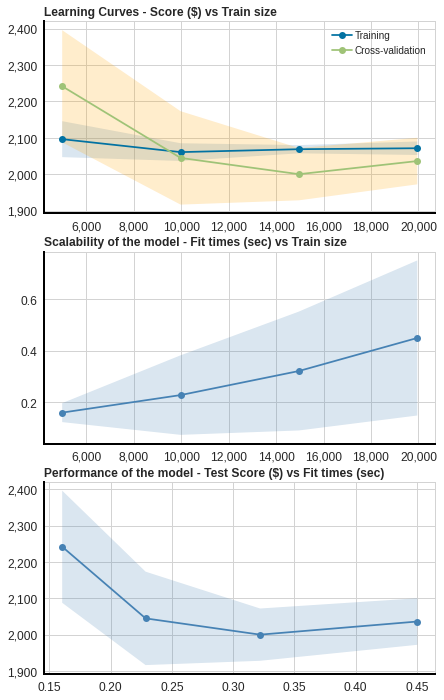

In [34]:
%%time
scores, train_sizes = learning_curve(best_pipe, X_all, y_all, cv, 5, best_t)
scores_grouped = scores.groupby(["train_size"]).agg({"train_err": ["mean", "std"], "test_err": ["mean", "std"], "fit_time": ["mean", "std"], "clf":"first"}).reset_index()
scores_grouped.columns = scores_grouped.columns.map('|'.join)
display(scores_grouped)
manual_learning_curve(
    scores_grouped,
    alpha=0.2,
    hspace=0.2,
    wspace=0.2,
    axis_tick_label_fontsize=12,
    figsize=(7, 12),
)

**Observations**
1. Both training and cross-validation errors are larger (more negative) than $\$$1,000. If the business objective was to predict the average return<sup>[1](#myfootnote1)</sup>
 per loan to within $\$$1,000 of the true return<sup>[1](#myfootnote1)</sup> earned per loan, then the error in the model's predictions (both on training and cross-validation splits of the data) would be considered high. This is an indication that the model's predictions suffer from high bias.
2. The gap between the two learning curves is small, indicating the presence of low variance in the model's predictions.
3. Combined, this indicates that the best model with the selected discrimination threshold is underfitting the training data. Adding data is unlikely to remedy this problem. This is seen from the convergence of the two learning curves as the size of the training data is increased.
4. Further work should focus on extracting more features from the dataset - currently only a single ML feature `is_employed` (a binary column indicating whether the applicant was employed or not at the time of applying for the loan on Lending Club) was extracted.

<a name="myfootnote1">1</a>: or loss, depending on whether the loan is paid off on time or not

In [ ]:
# y_pred_test_selected_threshold_series = pd.Series(
#     y_pred_test_selected_threshold, index=X_test.index, name="pred"
# )
# df_tp = df[["addr_state"]].merge(
#     pd.concat(
#         [
#             X_test[
#                 [
#                     "purpose",
#                     "home_ownership",
#                     "emp_length",
#                     "term",
#                 ]
#                 + numerical_columns
#             ],
#             y_test,
#             y_pred_test_selected_threshold_series,
#         ],
#         axis=1,
#     ),
#     left_index=True,
#     right_index=True,
#     how="inner",
# )

In [ ]:
# df_tp["misclassified"] = df_tp["is_default"] != df_tp["pred"]
# display(df_tp)
# display(df_tp.dtypes.to_frame())

In [ ]:
# for c in numerical_columns:
#     plot_grouped_histogram(df_tp, c, (0.675, 1.1), 0.5, 0.15, (12, 4))

In [ ]:
# for col, wspace, fig_size in zip(
#     ["home_ownership", "purpose", "emp_length", "term", "addr_state"],
#     [0.25, 0.4, 0.1, 0.25, 0.1],
#     [(12, 4), (12, 4), (12, 4), (12, 4), (12, 8)],
# ):
#     plot_grouped_bar_chart(df_tp, col, "misclassified", wspace, fig_size=fig_size)

## Links
1. [Find row closest to a value](https://stackoverflow.com/a/52587453/4057186)